<a href="https://colab.research.google.com/github/jermwatt/machine_learning_refined/blob/main/notes/6_Linear_twoclass_classification/6_4_Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 6: Linear two-class classification

# The Perceptron

As we have seen with logistic regression we treat classification as a particular form of nonlinear regression (employing - with the choice of label values $y_p \in \left\{-1,+1\right\}$ - a tanh nonlinearity).  This results in the learning of a proper nonlinear regressor, and a corresponding *linear decision boundary* 

\begin{equation}
\mathring{\mathbf{x}}_{\,}^{T}\mathbf{w}^{\,}=0.
\end{equation}

Instead of learning this decision boundary as a result of a nonlinear regression, the *perceptron* derivation described in this Section aims at determining this ideal lineary decision boundary directly.  While we will see how this direct approach leads back to the *Softmax cost function*, and that practically speaking the perceptron and logistic regression *often results in learning the same linear decision boundary*, the perceptron's focus on learning the decision boundary directly provides a valuable new perspective on the process of two-class classification.  In particular - as we will see here - the perceptron provides a simple geometric context for introducing the important concept of *regularization* (an idea we will see arise in various forms throughout the remainder of the text).

In [1]:
# import standard libs
import os

# if on collab pull required subdirectories
if os.getenv("COLAB_RELEASE_TAG"): 
    # install github clone - allows for easy cloning of subdirectories
    !pip install github-clone
    from pathlib import Path 

    # clone datasets
    if not Path('chapter_6_datasets').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/6_Linear_twoclass_classification/chapter_6_datasets
    else:
        print('chapter_6_datasets already cloned!')

    # clone library subdirectory
    if not Path('chapter_6_library').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/6_Linear_twoclass_classification/chapter_6_library
    else:
        print('chapter_6_library already cloned!')

    # clone images
    if not Path('chapter_6_images').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/6_Linear_twoclass_classification/chapter_6_images
    else:
        print('chapter_6_images already cloned!')

# append path for local library, data, and image import
import sys
sys.path.append('./chapter_6_library')
sys.path.append('./chapter_6_datasets') 
sys.path.append('./chapter_6_images') 

# import section helper
import section_6_4_helpers

# dataset paths
data_path_1 = 'chapter_6_datasets/2d_classification_data_v1.csv'

# image paths
image_path_1 = 'chapter_6_images/Fig_4_1.png'
image_path_2 = 'chapter_6_images/Fig_4_2.png'
image_path_3 = 'chapter_6_images/point_distance.png'
image_path_4 = 'chapter_6_images/distance_to_boundary.png'

# standard imports
import matplotlib.pyplot as plt
from IPython.display import Image, HTML

# import autograd-wrapped numpy
import autograd.numpy as np

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=3dbe28e6493fa7bcb50e0b347964318b6b021a13f4e3eee632e9e35ec59ab87b
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt
Cloning into 'chapter_6_datasets'...
done.
Cloning into 'chapter_6_library'...
done.
Cloning into 'chapter_6_images'...
done.


## The Perceptron cost function

With two-class classification we have a training set of $P$ points $\left\{ \left(\mathbf{x}_{p},y_{p}\right)\right\} _{p=1}^{P}$ - where $y_p$'s take on just two label values from $\{-1, +1\}$ - consisting of two classes which we would like to learn how to distinguish between automatically.  As we saw in our discussion of logistic regression, in the simplest instance our two classes of data are largely separated by a *linear decision boundary* with each class (largely) lying on either side.  This decision boundary, written as

\begin{equation}
\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,} = 0,
\end{equation}

is a *point* when the dimension of the input is $N=1$ (as we saw in e.g., Example 2 of the previous Section), a *line* when $N = 2$ (as we saw in e.g, Example 3 of the previous Section), and is more generally for arbitray $N$ a *hyperplane* defined in the input space of a dataset.  This scenario can be best visualized in the case $N=2$, where we view the problem of classification 'from above' - showing the input of a dataset colored to denote class membership.  The default coloring scheme we use here - matching the scheme used in the previous Section - is to color points with label $y_p = -1$ blue and $y_p = +1$ red.  The linear decision boundary is here a line that best separates points from the $y_p = -1$ class from those of the $y_p = +1$ class, as shown figuratively in the panels below.

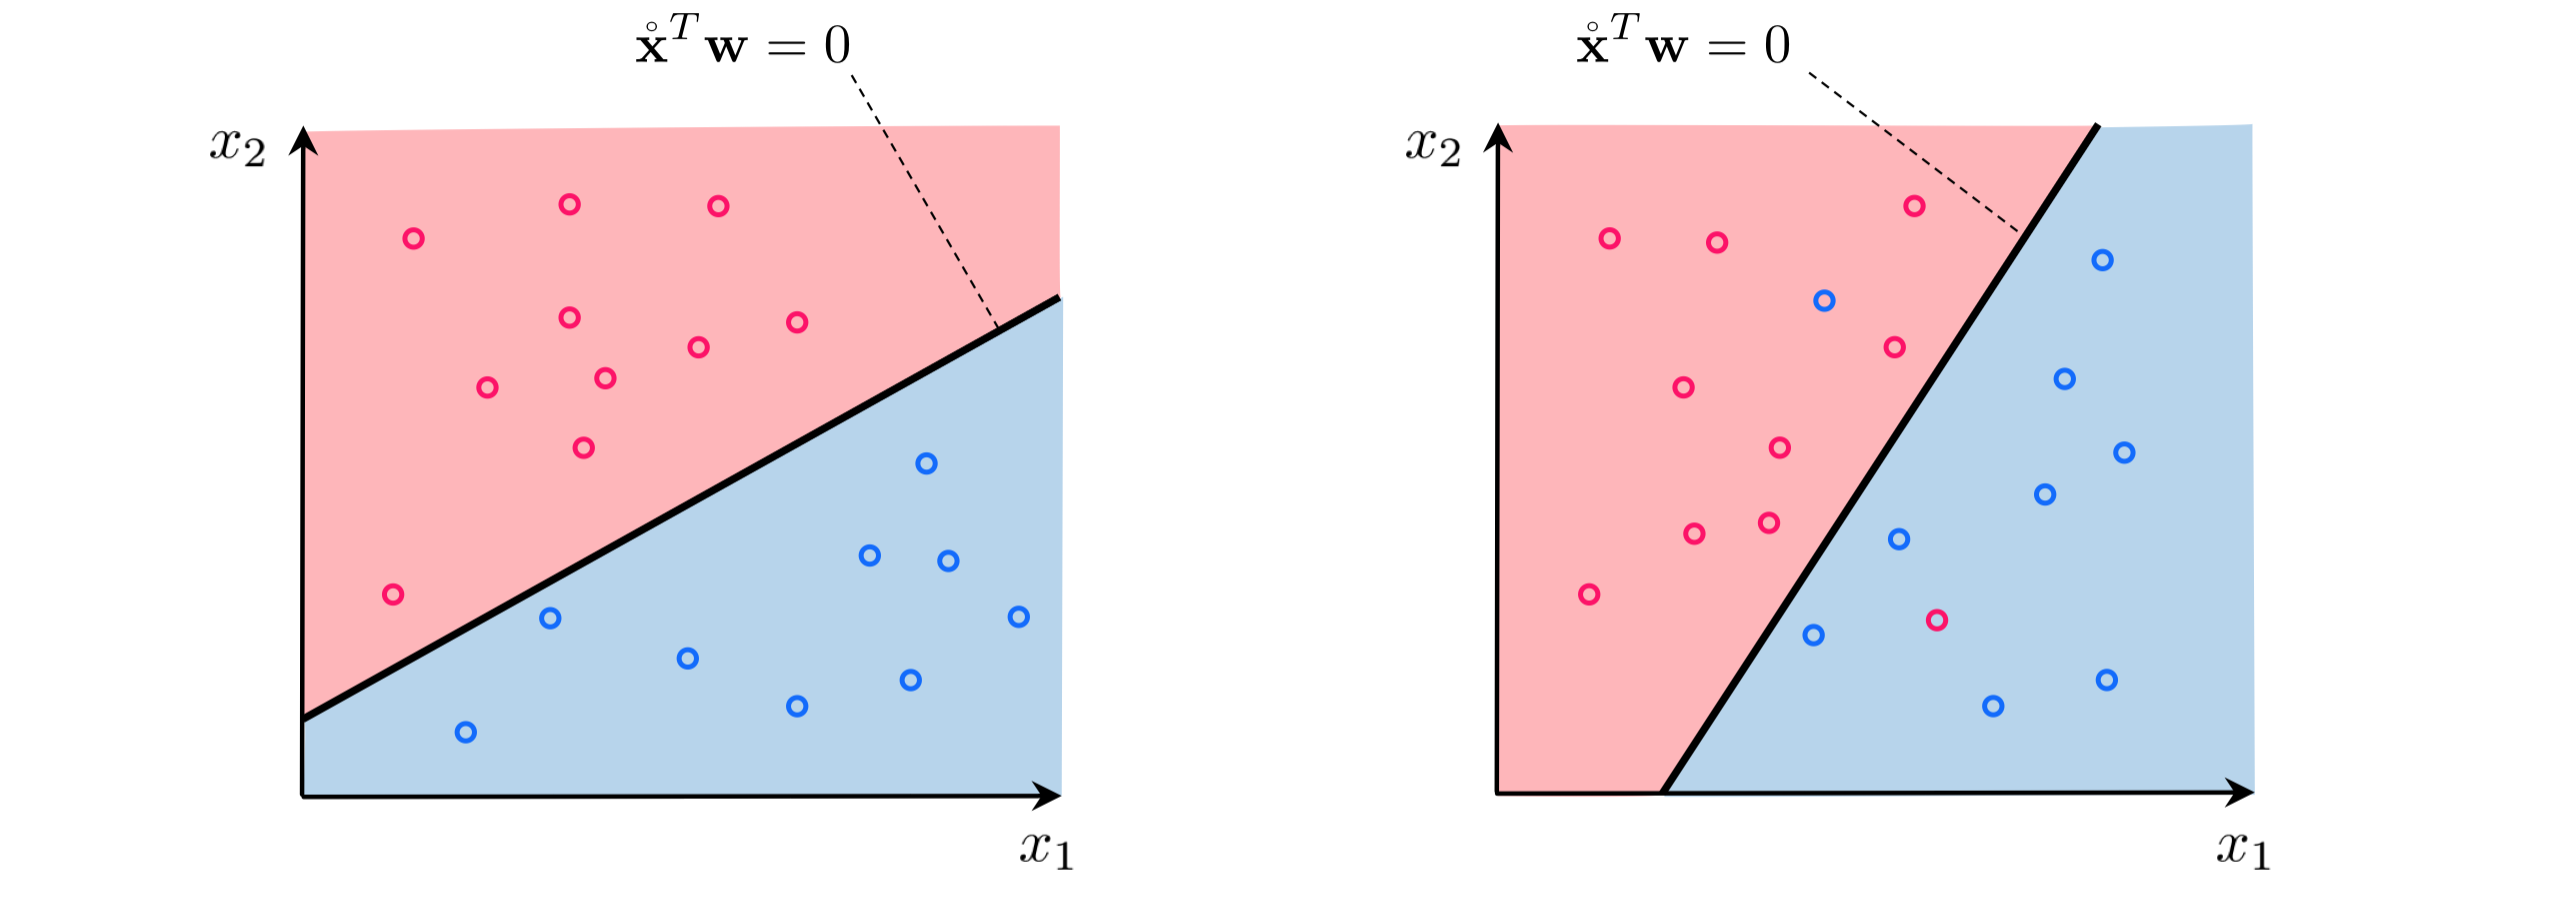

In [2]:
Image(image_path_1, width=800)

<figure>
  <figcaption>   
<strong>Figure 1:</strong> <em> With the perceptron we aim to directly
 learn the linear decision boundary $\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,} =0$ (shown
here in black) to separate two classes of data, colored red (class $+1$) and blue (class $-1$), by dividing the input space into a red half-space where $\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,} >0$,
and a blue half-space where $\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,} <0$. (left
panel) A linearly separable dataset where it is possible to learn
a hyperplane to perfectly separate the two classes. (right panel)
A dataset with two overlapping classes. Although the distribution
of data does not allow for perfect linear separation, the perceptron still aims to find
a hyperplane that minimizes the number of misclassified points
that end up in the wrong half-space.</em>  </figcaption> 
</figure>

A linear decision boundary cuts the input space into two *half-spaces*, one lying 'above' the hyperplane where $\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,} > 0$ and one lying 'below' it where $\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}  < 0$.  Notice then, as depicted visually in the figure above, that a proper set of weights $\mathbf{w}$ define a linear decision boundary that separates a two-class dataset as well as possible with *as many members of one class as possible lying above it, and likewise as many members as possible of the other class lying below it*.  Because we can always flip the orientation of an ideal hyperplane by multiplying it by $-1$ (or likewise because we can always swap our two label values) we can say more specifically that when the weights of a hyperplane are tuned properly members of the class $y_p = +1$ lie (mostly)'above' it, while members of the $y_p = -1$ class lie (mostly) 'below' it.  In other words, our *desired* set of weights define a hyperplane where as often as possible we have that

\begin{equation}
\begin{array}
\
\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,} >0 & \,\,\,\,\text{if} \,\,\, y_{p}=+1\\
\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,} <0 & \,\,\,\,\text{if} \,\,\, y_{p}=-1.
\end{array}
\end{equation}

Because of our choice of label values we can consolidate the ideal conditions above into the single equation below

\begin{equation}
-\overset{\,}{y}_{p}\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,} <0.
\end{equation}

Again we can do so specifically because we chose the label values $y_p \in \{-1,+1\}$.  Likewise by taking the maximum of this quantity and zero we can then write this ideal condition, which states that a hyperplane correctly classifies the point $\mathbf{x}_{p}$, equivalently forming a *point-wise cost*

\begin{equation}
g_p\left(\mathbf{w}\right) = \text{max}\left(0,\,-\overset{\,}{y}_{p}\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,}\right)=0
\end{equation}

Note that the expression $\text{max}\left(0,-\overset{\,}{y}_{p}\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,}\right)$ is always nonnegative, since it returns zero if $\mathbf{x}_{p}$ is classified correctly, and returns a *positive value* if the
point is classified incorrectly.  The functional form of this point-wise cost $\text{max}\left(0,\cdot\right)$ is called a *rectified linear unit* (see the Appendix of this text for a historical explination of this term).  Because these point-wise costs are nonnegative and equal *zero* when our weights are tuned correctly, we can take their average over the entire dataset to form a proper cost function as

\begin{equation}
g\left(\mathbf{w}\right)=  \frac{1}{P}\sum_{p=1}^Pg_p\left(\mathbf{w}\right) = \frac{1}{P}\sum_{p=1}^P\text{max}\left(0,-\overset{\,}{y}_{p}\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,}\right).
\end{equation}

When minimized appropriately this cost function can be used to recover the ideal weights satisfying equations (3) - (5) as often as possible. 

This cost function goes by many names such as the *perceptron* cost, the *rectified linear unit* cost (or *ReLU cost* for short), and the *hinge cost* (since when plotted a ReLU function looks like a hinge). This cost function is *always convex* but has only a single (discontinuous) derivative in each input dimension. This implies that we can only use zero and first order local optimization schemes (i.e., not Newton's method).  Note that the perceptron cost *always* has a trivial solution at  $\mathbf{w} = \mathbf{0}$, since indeed $g\left(\mathbf{0}\right) = 0$, thus one may need to take care in practice to avoid finding it (or a point too close to it) accidentally.

##  The smooth softmax approximation to the ReLU cost

Learning and optimization go hand in hand, and as we know from the discussion above the ReLU function limits the number of optimization tools we can bring to bear for learning. It not only prohibits the use of Newton's method but forces us to be very careful about how we choose our steplength parameter $\alpha$ with gradient descent as well (as detailed in the example above). Here we describe a common approach to ameliorating this issue by introducing a smooth approximation to this cost function. This practical idea takes many forms depending on the cost function at play, but the general idea is this: when dealing with a cost function that has some deficit (insofar as local optimization is concerned) replace it with a smooth (or at least twice differentiable) cost function that closely matches it everywhere. If the approximation closely matches the true cost function then for the small amount of accuracy (we will after all be minimizing the approximation, not the true function itself) we significantly broaden the set of optimization tools we can use.

One popular way of doing this for the ReLU cost function is via the *softmax* function defined as

\begin{equation}
\text{soft}\left(s_0,s_1,...,s_{C-1}\right) = \text{log}\left(e^{s_0} + e^{s_1} + \cdots + e^{s_{C-1}} \right)
\end{equation}

where $s_0,\,s_1,\,...,s_{C-1}$ are any $C$ scalar vaules - which is a generic smooth approximation to the *max* function, i.e., 

\begin{equation}
\text{soft}\left(s_0,s_1,...,s_{C-1}\right) \approx \text{max}\left(s_0,s_1,...,s_{C-1}\right)
\end{equation}

To see why the softmax approximates the max function let us look at the simple case when $C = 2$. 

Suppose momentarily that $s_{0}\leq s_{1}$, so that $\mbox{max}\left(s_{0},\,s_{1}\right)=s_{1}$.  Therefore $\mbox{max}\left(s_{0},\,s_{1}\right)$ can be written as $\mbox{max}\left(s_{0},\,s_{1}\right)=s_{0}+\left(s_{1}-s_{0}\right)$,
or equivalently as $\mbox{max}\left(s_{0},\,s_{1}\right)=\mbox{log}\left(e^{s_{0}}\right)+\mbox{log}\left(e^{s_{1}-s_{0}}\right)$. Written in this
way we can see that $\mbox{log}\left(e^{s_{0}}\right)+\mbox{log}\left(1+e^{s_{1} s_{0}}\right)=\mbox{log}\left(e^{s_{0}}+e^{s_{1}}\right)=\mbox{soft}\left(s_{0},s_{1}\right)$ is always larger than $\mbox{max}\left(s_{0},\,s_{1}\right)$ but not by much, especially when $e^{s_{1}-s_{0}}\gg1$. Since the same argument can be made if $s_{0}\geq s_{1}$ we can say generally that
$ $$\mbox{soft}\left(s_{0},s_{1}\right)\approx\mbox{max}\left(s_{0},s_{1}\right)$.  The more general case follows similarly as well.

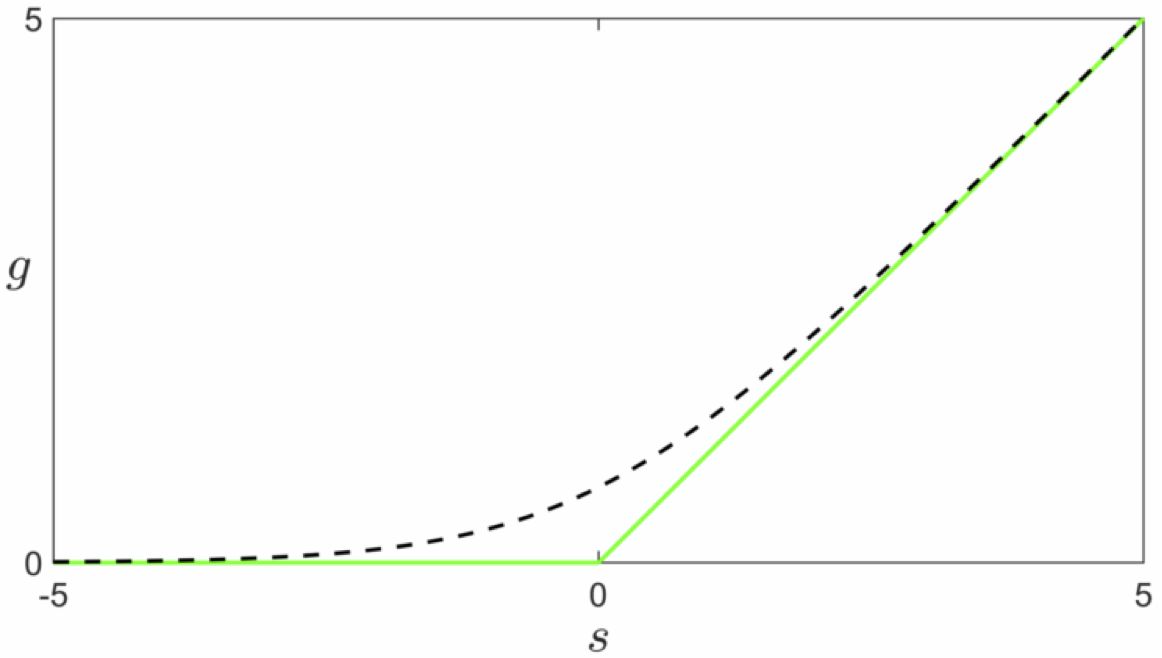

In [5]:
Image(image_path_2, width=400)

<figure>
  <figcaption>   
<strong>Figure 2:</strong> <em> 
    Plots of the ReLU
perceptron $g\left(s\right)=\mbox{max}\left(0,\,s\right)$
(shown in green) as well as its smooth softmax approximation $g\left(s\right)=\mbox{soft}\left(0,\,s\right)=\mbox{log}\left(1+e^{s}\right)$
(shown in dashed black).
    </em>  </figcaption> 
</figure>

Returning to the ReLU perceptron cost function in equation (5), we replace the $p^{th}$ summand with its softmax approximation, making this our point-wise cost

\begin{equation}
g_p\left(\mathbf{w}\right) = \text{soft}\left(0,-\overset{\,}{y}_{p}\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,}\right)= \text{log}\left(e^{0} + e^{-\overset{\,}{y}_{p}\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,}}\right) = \text{log}\left(1 + e^{-\overset{\,}{y}_{p}\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,}}\right)
\end{equation}

giving the overall cost function as 

\begin{equation}
g\left(\mathbf{w}\right)=\sum_{p=1}^P g_p\left(\mathbf{w}\right) = \underset{p=1}{\overset{P}{\sum}}\text{log}\left(1 + e^{-\overset{\,}{y}_{p}\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,}}\right)
\end{equation}

which is the *Softmax cost* we saw previously derived from the logistic regression perspective on two-class classification in the previous Section.  This is why the cost is called *Softmax*, since it derives from the general softmax approximation to the max function.

Note that *like* the ReLU cost - as we already know - the Softmax cost is convex. However *unlike* the ReLU cost, the softmax has infinitely many derivatives and Newton's method can therefore be used to minimize it. Moreover, softmax does not have a trivial solution at zero like the ReLU cost does.  Nonetheless, the fact that the Softmax cost so closely approximates the ReLU shows just how closely aligned - in the end - both logistic regression and the perceptron truly are. Practically speaking their differences lie in how well - for a particular dataset - one can optimize either one, along with (what is very often slight) differences in the quality of each cost function's learned decision boundary.  Of course when the Softmax is employed from the perceptron perspective there is no qualitative difference between the perceptron and logistic regression at all.

## A technical problem with linearly separable datasets 

Imagine that we have a dataset whose two classes can be perfectly separated by a hyperplane, and that we have chosen an appropriate cost function to minimize it in order to determine proper weights for our model.  Imagine further that we are *extremely lucky* and  our *initialization* $\mathbf{w}^0$ produces a linear decision boundary $\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{0} = 0$  with *perfect sepearation*.  This means that - according to equation (4) - that for each of our $P$ points we have that  

\begin{equation}
-\overset{\,}{y}_{p}\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{0} <0
\end{equation}

and likewise that the point-wise RelLU cost in equation (5) is zero for every point i.e., $g_p\left(\mathbf{w}^0\right) = \text{max}\left(0,\,-\overset{\,}{y}_{p}\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{0}\right)=0$ and so the ReLU cost is *exactly equal to zero*

\begin{equation}
g\left(\mathbf{w}^0\right) = \frac{1}{P}\sum_{p=1}^P\text{max}\left(0,-\overset{\,}{y}_{p}\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{0}\right) = 0.
\end{equation}

Since the ReLU cost value is already zero, its lowest value, this means that we would *halt our local optimization immediately*.  For example, since the gradient of this cost is also zero at $\mathbf{w}^0$ (see Example 1 above where the form of this gradient was given) a gradient descent step would not move us from $\mathbf{w}^0$.  However this will *not* happen if we instead employed the Softmax cost.

Since the quantity $-\overset{\,}{y}_{p}\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{0} <0$ its *negative exponential* is *larger than zero* i.e., $e^{-\overset{\,}{y}_{p}\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{0}} > 0$, which means that the softmax point-wise cost is also nonnegative $g_p\left(\mathbf{w}^0\right) = \text{log}\left(1 + e^{-\overset{\,}{y}_{p}\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{0}}\right) > 0$ and hence too the Softmax cost is nonnegative as well 

\begin{equation}
g\left(\mathbf{w}^0\right)= \sum_{p=1}^P\text{log}\left(1 + e^{-\overset{\,}{y}_{p}\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{0}}\right) > 0.
\end{equation}

This means that we in applying any local optimization scheme like e.g., gradient descent we will *indeed* take steps away from $\mathbf{w}^0$ in order to drive the value of the Softmax cost lower and lower towards its minimum at zero.  In fact - with data that is indeed linearly separable - the Softmax cost achieves this lower bound *only when the magnitude of the weights grows to infinity*.  This is clear from the fact each individual term $\text{log}\left(1 + e^{-C}\right) = 0$ only as $C \longrightarrow \infty$.  Indeed if we *multiply our initialization $\mathbf{w}^0$* by any constant $C > 1$ we can *decrease* the value of any negative exponential involving one of our data points since $e^{-C} < 1$ and so

\begin{equation}
e^{-\overset{\,}{y}_{p}\mathring{\mathbf{x}}_{p}^TC\mathbf{w}^{0}} = e^{-C}e^{-\overset{\,}{y}_{p}\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{0}} < e^{-\overset{\,}{y}_{p}\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{0}}.
\end{equation}

This likewise decreases the Softmax cost as well with the minimum achieved only as $C \longrightarrow \infty$.  Note however that regardless of the scalar $C > 1$ value involved the *decision boundary defined by the initial weights $\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{0} = 0$ does not change location, since we still have that $C\,\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{0} = 0$* (indeed this is true for any non-zero scalar $C$).  So even though the location of the separating hyperplane need not change, with the Softmax cost we still take more and more steps in minimization since (in the case of linearly separable data) its minimum lies off at infinity.  This can cause severe numerical instability issues with local optimizaiton schemes that make *large progress* at each step - particularly Newton's method - since they will tend to rapidly diverge to infinity.

Notice: because the Softmax and Cross-Entropy costs are equivalent (as discussed in the previous Section), this issue equally presents itself when using the Cross-Entropy cost as well.

#### <span style="color:#a50e3e;">Example 2: </span> Using Newton's method to minimize the Softmax cost

In applying Newton's method to minimize the Softmax over linearly separable data it is easily possible to run into numerical instability issues as the global minimum of the cost technically lies at infinity.  Here we examine a simple instance of this behavior using the single input dataset shown in the previous Section.  In this example we illustrate the progress of 5 Newton steps beginning at the point $\mathbf{w} = \begin{bmatrix} 1 \\ 1 \end{bmatrix}$.  Within 5 steps we have reached a point providing a very good fit to the data (here we plot the $\text{tanh}\left(\cdot\right)$ fit using the logistic regressoion perspective on the Softmax cost), and one that is already quite large in magnitude (as can be seen in the right panel below).  We can see here by the trajectory of the steps, which are traveling linearly towards the mininum out at $\begin{bmatrix} -\infty \\ \infty \end{bmatrix}$, that the location of the linear decision boundary (here a point) is not changing after the first step or two. In other words, after the first few steps we each subsequent step is simply multiplying its predecessor by a scalar value $C > 1$.

/usr/local/lib/python3.9/dist-packages/autograd/tracer.py:48: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return f_raw(*args, **kwargs)


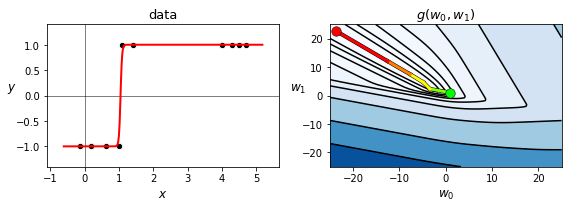

In [6]:
### define softmax cost ###
# compute linear combination of input point
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

# the convex softmax cost function
def softmax(w):
    cost = np.sum(np.log(1 + np.exp(-y*model(x,w))))
    return cost/float(np.size(y))

# load in dataset
data = np.loadtxt(data_path_1, delimiter = ',')

# get input/output pairs
x = data[:-1,:]
y = data[-1:,:] 

# run gradient descent to minimize the softmax cost
g = softmax; w = np.ones((2,1)); max_its = 5;
weight_history,cost_history = section_6_4_helpers.newtons_method(g,max_its,w,epsilon = 10**(-7))

# create a static figure illustrating gradient descent steps 
animator = section_6_4_helpers.classification_2d_visualizer(data,g)
animator.static_fig(weight_history,num_contours = 25,viewmax = 25)

Notice that if we simply flip one of the labels - making this dataset not perfectly linearly separable - the corresponding cost function does not have a global minimum out at infinity, as illustrated in the contour plot below.

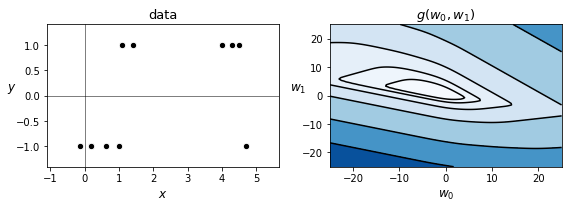

In [7]:
# switch a label
y[0,-1] = -1
data = np.vstack((x,y))

# draw contour of this new data
animator = section_6_4_helpers.classification_2d_visualizer(data,softmax)

# create a static figure illustrating gradient descent steps 
animator.static_fig([],num_contours = 15,viewmax = 25)

 ##  Regularization and two-class classification

How can we prevent this potential problem when employing the Softmax or Cross-Entropy cost?  One approach can be to employ our local optimization schemes more carefully by eg., taking fewer steps and / or halting a scheme if the magnitude of the weights grows larger than a large pre-defined constant (this is called *early-stopping*).  Another approach is to *control the magnitude of the weights during the optimization procedure itself*.  Both approaches are generally referred to in the jargon of machine learning as *regularization strategies*.  The former strategy is straightfoward, requiring slight adjustments to the way we have typically employed local optimization, but the latter approach requires some further explanation which we now provide. 

To control the magnitude of $\mathbf{w}$ means that we want to control the size of the $N+1$ individual weights it contains

\begin{equation}
\mathbf{w} = 
\begin{bmatrix}
w_0 \\
w_1 \\
\vdots \\
w_N
\end{bmatrix}.
\end{equation}

We can do this by *directly* controling the size of just $N$ of these weights, and it is particularly convenient to do so using the final $N$ feature touching weights $w_1,\,w_2,\,...,w_N$ because these define the *normal vector* to the linear decision boundary $\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,} = 0$.  To more easily introduce the geometric concepts that follow we will use our bias / feature weight notation for $\mathbf{w}$ first introduced in [Section 5.2](https://jermwatt.github.io/machine_learning_refined/notes/5_Linear_regression/5_2_Least.html).  This provides us with individual notation for the bias and feature-touching weights as

\begin{equation}
\text{(bias):}\,\, b = w_0 \,\,\,\,\,\,\,\, \text{(feature-touching weights):} \,\,\,\,\,\, \boldsymbol{\omega} = 
\begin{bmatrix}
w_1 \\
w_2 \\ 
\vdots \\
w_N
\end{bmatrix}.
\end{equation}

With this notation we can express a linear decision boundary as

\begin{equation}
\mathring{\mathbf{x}}_{\,}^T \mathbf{w} = b + \overset{\,}{\mathbf{x}}_{\,}^T\boldsymbol{\omega} = 0.
\end{equation}

To begin to see why this notation is useful first note how - geometrically speaking - the feature-touching weights $\boldsymbol{\omega}$ define the *normal vector of the linear decision boundary*.  The *normal* vector to a hyperplane (like our decision boundary) is always *perpindicular* to it - as illustrated in the Figure below.  We can *always compute the error - also called the *signed* distance - of a point $\mathbf{x}_p$ to a linear decision boundary in terms of the normal vector $\boldsymbol{\omega}$*.  

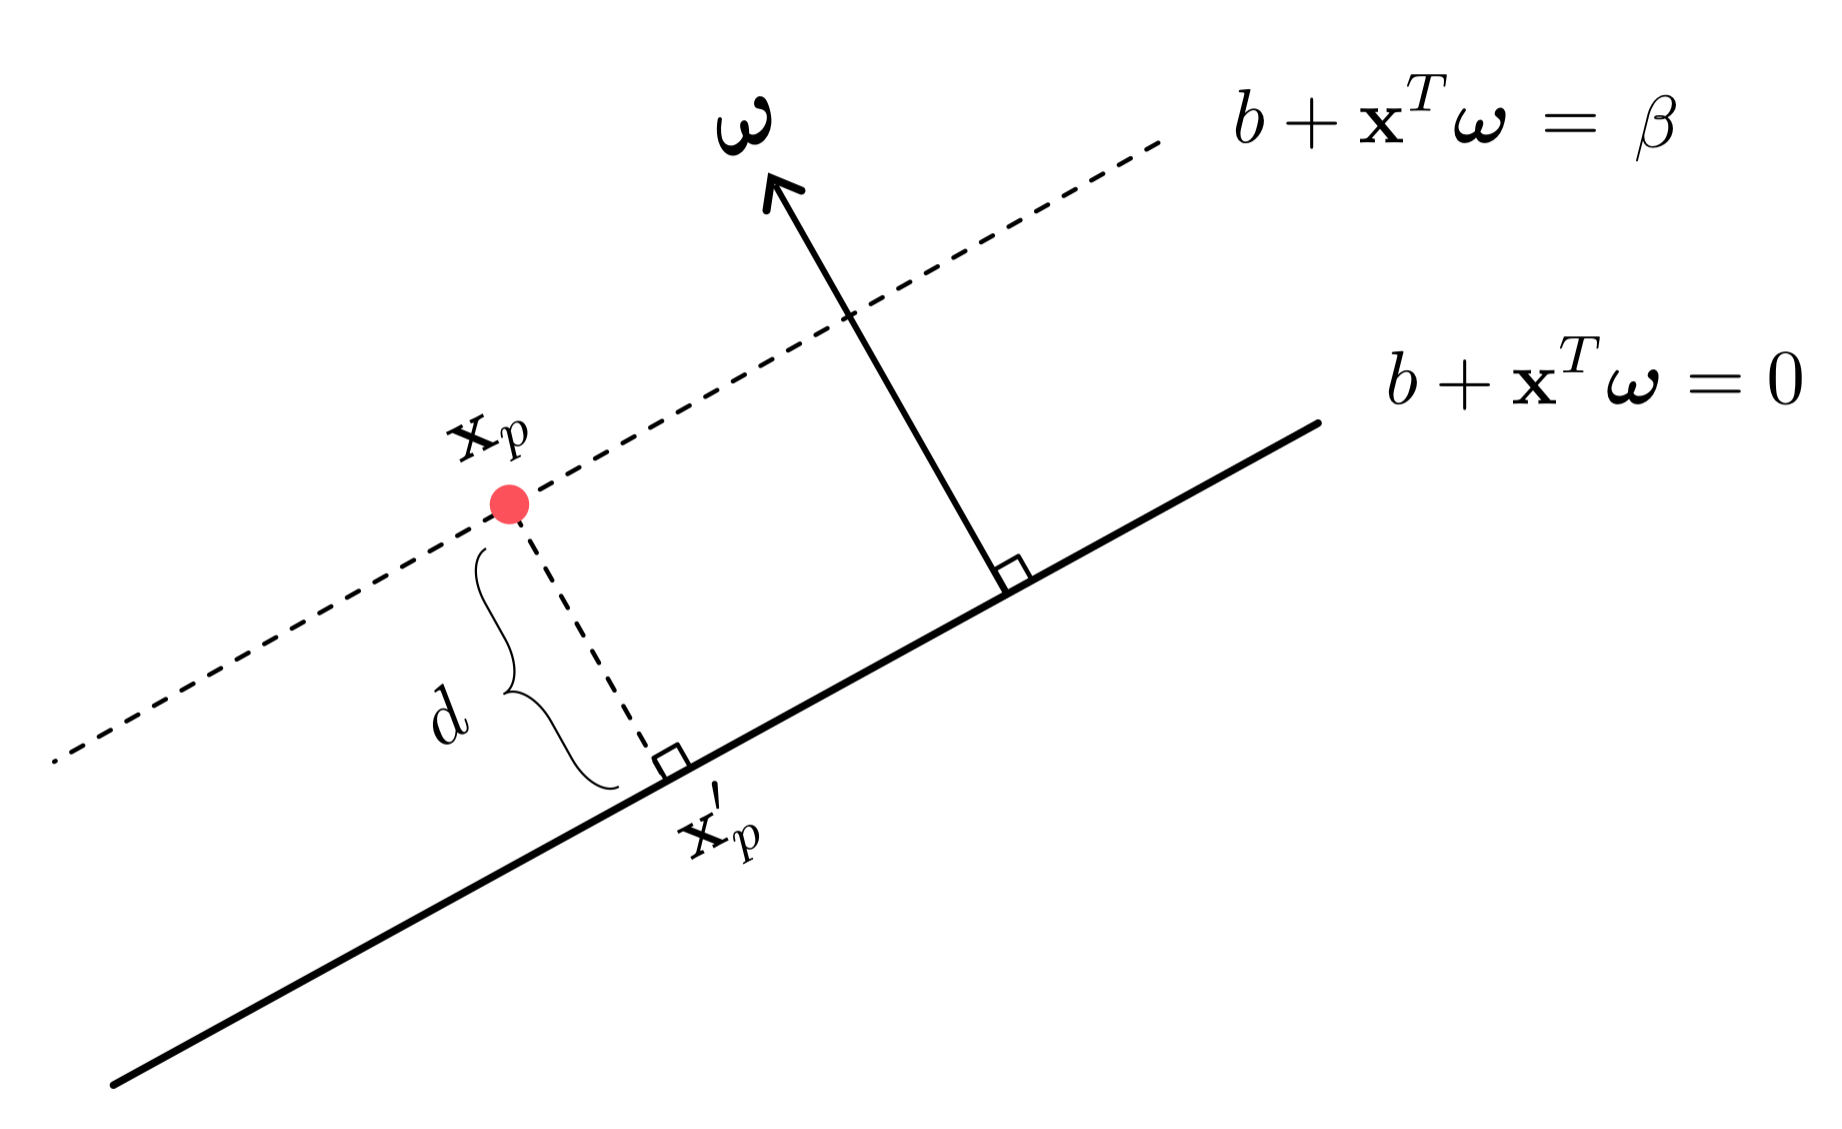

In [10]:
Image(image_path_3, width=500)

<figure>
  <figcaption>   
<strong>Figure 3:</strong> <em> 
A linear decision boundary written as $ b + \overset{\,}{\mathbf{x}}_{\,}^T\boldsymbol{\omega} = 0$ has a normal vector $\boldsymbol{\omega}$ defined by its feature-touching weights.  To compute the signed distance of a point $\mathbf{x}_p$ to the boundary we mark the translation of the decision boundary passing through this point as $ b + \overset{\,}{\mathbf{x}}_{\,}^T\boldsymbol{\omega} = \beta$, and the projection of the point onto the decision boundary as $\mathbf{x}_p^{\prime}$.
    </em>  </figcaption> 
</figure>

To see how this is possible, imagine we have a point $\mathbf{x}_p$ lying 'above' the linear decision boundary on a translate of the decision boundary where  $b + \overset{\,}{\mathbf{x}}_{\,}^T\boldsymbol{\omega} = \beta > 0$, as illustrated in the Figure above.  The same simple argument that follows can be made if $\mathbf{x}_p$ lies 'below' it as well.  To compute the distance of $\mathbf{x}_p$ to the decision boundary imagine we know the location of its *vertical projection* onto the decision boundary which will call $\mathbf{x}_p^{\prime}$.  To compute our desired error we want to compute the signed distance between $\mathbf{x}_p$ and its vertical projection, i.e., the length of the vector $\mathbf{x}_p^{\prime} -  \mathbf{x}_p$ times the sign of $\beta$ which here is $+1$ since we assume the point lies above the decision boundary hence $\beta > 0$, i.e., $d = \left\Vert \mathbf{x}_p^{\prime} -  \mathbf{x}_p \right\Vert_2 \text{sign}\left(\beta\right) = \left\Vert \mathbf{x}_p^{\prime} -  \mathbf{x}_p \right\Vert_2$.  Now, because *this vector is also perpindicular* to the decision boundary (and so is *paralell* to the normal vector $\boldsymbol{\omega}$)  the *inner-product rule* gives

\begin{equation}
\left(\mathbf{x}_p^{\prime} -  \mathbf{x}_p\right)^T\boldsymbol{\omega} = \left\Vert \mathbf{x}_p^{\prime} -  \mathbf{x}_p \right\Vert_2 \left\Vert \overset{\,}{\boldsymbol{\omega}} \right\Vert_2 = d\,\left\Vert \overset{\,}{\boldsymbol{\omega}} \right\Vert_2 
\end{equation}

Now if we take the difference between our decision boundary and its translation evaluated at $\mathbf{x}_p^{\prime}$ and $\mathbf{x}_p$ respectively, we have simplifying

\begin{equation}
\beta - 0 = \left(b + \left(\overset{\,}{\mathbf{x}}_{p}^{\prime}\right)^T \boldsymbol{\omega}\right)- \left(b + \overset{\,}{\mathbf{x}}_{p}^T \boldsymbol{\omega}\right) = \left(\mathbf{x}_p^{\prime} -  \mathbf{x}_p\right)^T\boldsymbol{\omega}
\end{equation}

Since both formulae are equal to $\left(\mathbf{x}_p^{\prime} -  \mathbf{x}_p\right)^T\boldsymbol{\omega}$ we can set them equal to each other, which gives

\begin{equation}
d\,\left\Vert \overset{\,}{\boldsymbol{\omega}} \right\Vert_2 = \beta
\end{equation}

or in other words that the signed distance $d$ of $\mathbf{x}_p$ to the decision boundary is 

\begin{equation}
d = \frac{\beta}{\left\Vert \overset{\,}{\boldsymbol{\omega}} \right\Vert_2 } = \frac{b + \overset{\,}{\mathbf{x}}_{p}^T\boldsymbol{\omega} }{\left\Vert \overset{\,}{\boldsymbol{\omega}} \right\Vert_2 }.
\end{equation}

Note that we need not worry dividing by zero here since if the feature-touching weights $\boldsymbol{\omega}$ were all zero, this would imply that the bias $b = 0$ as well and we have no decision boundary at all.  Also notice, this analysis implies that if the feature-touching weights have *unit length* as $\left\Vert \boldsymbol{\omega}\right\Vert_2 = 1$ then the signed distance $d$ of a point $\mathbf{x}_p$ to the decision boundary is given *simply by its evaluation* $b + \mathbf{x}_p^T \boldsymbol{\omega}$.  Finally note that if $\mathbf{x}_p$ were to lie below the decision boundary and $\beta < 0$ nothing about the final formulae derived above will change.

We mark this point-to-decision-boundary distance on points in the figure below, here the input dimension $N = 3$ and the decision boundary is a true hyperplane.

In [ ]:
IPython.display.HTML('''<img src="''' + image_path_4 + '''" width="60%" height="auto" alt=""/>''')

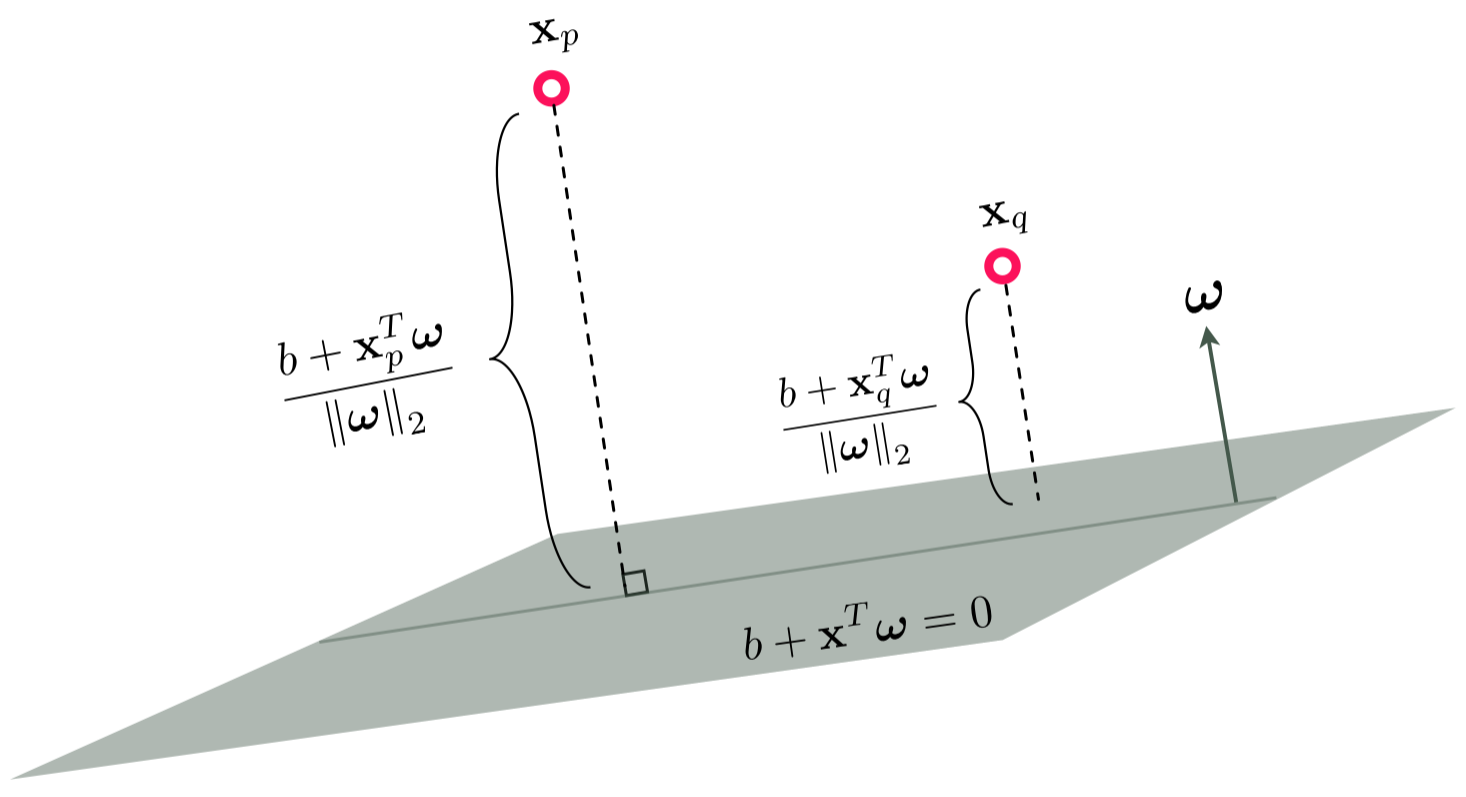

In [11]:
Image(image_path_4, width=600)

<figure>
  <figcaption>   
<strong>Figure 4:</strong> <em> Visual representation of the distance to the hyperplane $b+\mathbf{x}^T\boldsymbol{\omega}$, of two points $\mathbf{x}_p$ and $\mathbf{x}_q$ lying above it. </em>  </figcaption> 
</figure>

Remember, as detailed above, we can scale any linear decision boundary by a non-zero scalar $C$ and it still defines the same hyperplane.  So if - in particular - we multiply by $C = \frac{1}{\left\Vert \overset{\,}{\boldsymbol{\omega}} \right\Vert_2}$ we have

\begin{equation}
 \frac{b + \overset{\,}{\mathbf{x}}_{\,}^T\boldsymbol{\omega} }{\left\Vert \overset{\,}{\boldsymbol{\omega}} \right\Vert_2 } = \frac{b}{\left\Vert \overset{\,}{\boldsymbol{\omega}} \right\Vert_2} + \overset{\,}{\mathbf{x}}_{\,}^T\frac{\boldsymbol{\omega}}{\left\Vert \overset{\,}{\boldsymbol{\omega}} \right\Vert_2} = 0
\end{equation}

we do not change the nature of our decision boundary and now our feature-touching weights have unit length as $\left\Vert \frac{\boldsymbol{\omega}}{\left\Vert \overset{\,}{\boldsymbol{\omega}} \right\Vert_2}\right \Vert_2 = 1$.  In other words, *regardless of how large our weights $\mathbf{w}$ were to begin with we can always normalize them in a consistent way by dividing off the magnitude of $\boldsymbol{\omega}$*.  

This normalization scheme is particularly useful in the context of the technical issue with the Softmax / Cross-entropy highlighted in the previous Subsection. because clearly a decision boundary that perfectly separates two classes of data *can be feature-weight normalized* to prevent its weights from growing too large (and diverging too infinity).  Of coures we do not want to wait to perform this normaliation until *after* we run our local optimization, since this will not prevent the magnitude of the weights from potentially diverging, but *during* optimization.  

With can achieve this by *constraining* the Softmax / Cross-Entropy cost so that feature-touching weights always have length one i.e., $\left\Vert \boldsymbol{\omega} \right\Vert_2 = 1$.  Formally we can phrase this minimization (employing the Softmax cost) to as a *constrained* optimization problem as follows

\begin{equation}
\begin{aligned}
\underset{b, \,\boldsymbol{\omega}_{\,}}{\,\,\,\,\,\mbox{minimize}\,\,\,} & \,\,\,\, \frac{1}{P}\sum_{p=1}^P\text{log}\left(1 + e^{-y_p\left(b + \mathbf{x}_p^T \boldsymbol{\omega}^{\,}_{\,}\right)}\right) \\
\mbox{subject to}\,\,\, & \,\,\,\,\, \left \Vert \boldsymbol{\omega} \right \Vert_2^2 = 1
\end{aligned}
\end{equation}

By solving this *constrained* version of the Softmax cost we can still learn a decision boundary that perfectly separates two classes of data, but we avoid divergence in the magnitude of the weights by keeping their magnitude *feature-weight normalized*.

This formulation can indeed be solved by simple extensions of the local optimization methods detailed in Chapters 2 -4 (see this Chapter's exercises for further details).
However a more popular approach in the machine learning community is to 'relax' this constrinaed formulation and instead solve the highly related *unconstrained problem*.  This relaxed form of the problem consists in minimizing a cost functionn that is a linear combination of our original Softmax cost the magnitude of the feature weights 

\begin{equation}
g\left(b,\boldsymbol{\omega}\right) = \frac{1}{P}\sum_{p=1}^P\text{log}\left(1 + e^{-y_p\left(b + \mathbf{x}_p^T \boldsymbol{\omega}^{\,}_{\,}\right)}\right) + \lambda\, \left \Vert \boldsymbol{\omega} \right \Vert_2^2 
\end{equation}

which we can minimize using any of our familiar local optimization schemes.  Note here the *regularization parameter* $\lambda \geq 0$.  Here in adding the magnitude of the feature-touching weights to our Softmax cost we 'put pressure' on both terms, and aim to make both small.  The parameter $\lambda$ is used to balance how strongly we pressure one term or the other.  In minimizing the first term, our Softmax cost, we are still looking to learn an excellent linear decision boundary.  In also minimizing the second term, the magnitude of the feature-touching weights $\lambda\, \left \Vert \boldsymbol{\omega} \right \Vert_2^2$ also called a *regularizer* - we incentivize the learning of *small* weights.  This prevents the divergence of their magnitude since if their size does start to grow we our entire cost function 'suffers' because of it, and becomes large.  Because of this the value of $\lambda$ is typically chosen to be small (and positive) in practice, although some fine-tuning can be useful.  

#### <span style="color:#a50e3e;">Example 3: </span> Using Newton's method to minimize a regularized Softmax cost

Here we repeat the experiment of the previous Example, but add a regularizer with $\lambda = 10^(-3)$ to the Softmax cost.  In the right panel below we show the contour plot of the regularized cost function, and we can see its global minimum no longer lies at infinity.  However we still learn a perfect decision boundary as illustrated in the left panel by a tightly fitting $\text{tanh}\left(\cdot\right)$ function.

/usr/local/lib/python3.9/dist-packages/autograd/tracer.py:48: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return f_raw(*args, **kwargs)


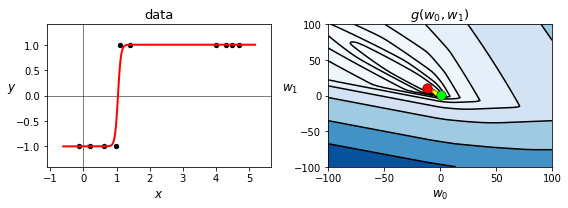

In [12]:
### define softmax cost ###
# compute linear combination of input point
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

# the convex softmax cost function
lam = 2*10**(-3)
def softmax(w):
    # compute cost value
    cost = np.sum(np.log(1 + np.exp(-y*model(x,w))))
    
    # add regularizer
    cost += lam*np.sum(w[1:]**2)
    return cost/float(np.size(y))

# load in dataset
data = np.loadtxt(data_path_1, delimiter = ',')

# get input/output pairs
x = data[:-1,:]
y = data[-1:,:] 

# run gradient descent to minimize the softmax cost
g = softmax; w = np.ones((2,1)); max_its = 5;
weight_history,cost_history = section_6_4_helpers.newtons_method(g,max_its,w,epsilon = 10**(-7))

# create instance of logisic regression demo and load in data, cost function, and descent history
animator = section_6_4_helpers.classification_2d_visualizer(data,softmax)

# create a static figure illustrating gradient descent steps 
animator.static_fig(weight_history,num_contours = 25,viewmax = 100)